# Model Training

This notebook holds a proof of concept of how the CreditKarma Scorer model would be trained using the gold table. CreditKarma Scorer is a binary classification logistic regression model that outputs the **probability of a customer defaulting their loan**. Loaning decisions are made by setting a threshold probability based on **F2-score**, as we want to be conservative in giving out loans and prioritize low-risk individuals (i.e. minimize false negatives from CreditKarma Scorer, which rates a high risk individual as low risk).

In [155]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import pickle


**Import data from gold table**

In [2]:
spark = pyspark.sql.SparkSession.builder \
    .appName("model-training") \
    .master("local[*]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 07:04:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/12 07:04:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [10]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df


In [5]:
X_spark = read_gold_table('feature_store', 'datamart/gold', spark)
y_spark = read_gold_table('label_store', 'datamart/gold', spark)

In [98]:
X_df = X_spark.toPandas().sort_values(by='customer_id')
y_df = y_spark.toPandas().sort_values(by='customer_id')

**Set train test split**

In [144]:
model_train_date_str = "2024-09-02" # pretend we're training the model at this time
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.2

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 

config

{'model_train_date_str': '2024-09-02',
 'train_test_period_months': 12,
 'oot_period_months': 2,
 'model_train_date': datetime.date(2024, 9, 2),
 'oot_end_date': datetime.date(2024, 9, 1),
 'oot_start_date': datetime.date(2024, 7, 2),
 'train_test_end_date': datetime.date(2024, 7, 1),
 'train_test_start_date': datetime.date(2023, 7, 2),
 'train_test_ratio': 0.2}

Split OOT

In [145]:
# Consider data from model training date
y_model_df = y_df[(y_df['snapshot_date'] >= config['train_test_start_date']) & (y_df['snapshot_date'] <= config['model_train_date'])]
X_model_df = X_df[np.isin(X_df['customer_id'], y_model_df['customer_id'].unique())]

# Create OOT split
y_oot = y_model_df[(y_model_df['snapshot_date'] >= config['oot_start_date']) & (y_model_df['snapshot_date'] <= config['oot_end_date'])]
X_oot = X_model_df[np.isin(X_model_df['customer_id'], y_oot['customer_id'].unique())]

# Everything else goes into train-test
y_traintest = y_model_df[y_model_df['snapshot_date'] <= config['train_test_end_date']]
X_traintest = X_model_df[np.isin(X_model_df['customer_id'], y_traintest['customer_id'].unique())]

Split train-test

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, 
                                                    test_size=config['train_test_ratio'], 
                                                    random_state=611, 
                                                    shuffle=True, 
                                                    stratify=y_traintest['label'])

In [158]:
# Transform data into numpy arrays
X_train_arr = X_train.drop(columns=['customer_id', 'snapshot_date']).values
X_test_arr = X_test.drop(columns=['customer_id', 'snapshot_date']).values
X_oot_arr = X_oot.drop(columns=['customer_id', 'snapshot_date']).values

y_train_arr = y_train['label'].values
y_test_arr = y_test['label'].values
y_oot_arr = y_oot['label'].values

Normalize data

In [159]:
scaler = StandardScaler()
X_train_arr = scaler.fit_transform(X_train_arr)
X_test_arr = scaler.transform(X_test_arr)
X_oot_arr = scaler.transform(X_oot_arr)

**Train CreditKarma Scorer**

In [163]:
# Train model
clf = LogisticRegression()
clf.fit(X_train_arr, y_train_arr)

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

**Evaluate CreditKarma Scorer**

In [164]:
# Load model
with open("model.pkl", "rb") as f:
    clf = pickle.load(f)

In [179]:
# Predict and evaluate
y_pred_proba_train = clf.predict_proba(X_train_arr)[:, 1]
train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)

y_pred_proba_test = clf.predict_proba(X_test_arr)[:, 1]
test_auc = roc_auc_score(y_test_arr, y_pred_proba_test)

y_pred_proba_oot = clf.predict_proba(X_oot_arr)[:, 1]
oot_auc = roc_auc_score(y_oot_arr, y_pred_proba_oot)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"OOT AUC: {oot_auc:.4f}")

Train AUC: 0.8788
Test AUC: 0.8284
OOT AUC: 0.9046


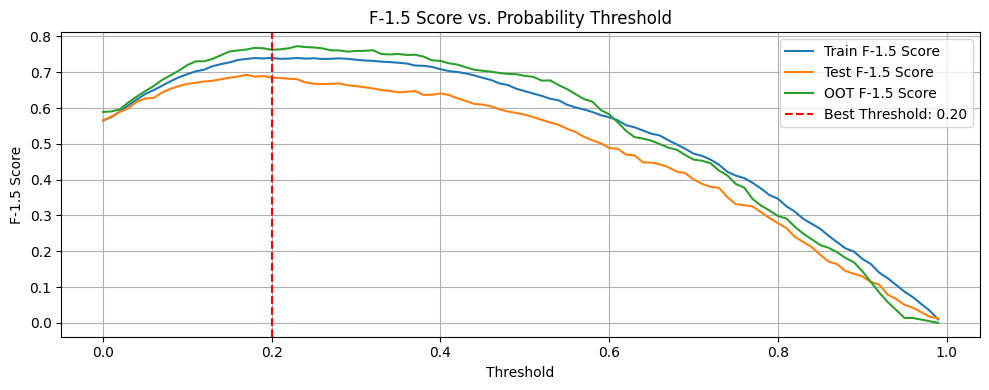

In [189]:
# F2 score across thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train_arr, y_pred_proba_train > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test_arr, y_pred_proba_test > t, beta=beta) for t in thresholds]
f1_scores_oot = [fbeta_score(y_oot_arr, y_pred_proba_oot > t, beta=beta) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores_train)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label=f"Train F-{beta} Score")
plt.plot(thresholds, f1_scores_test, label=f"Test F-{beta} Score")
plt.plot(thresholds, f1_scores_oot, label=f"OOT F-{beta} Score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.title(f"F-{beta} Score vs. Probability Threshold")
plt.xlabel("Threshold")
plt.ylabel(f"F-{beta} Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

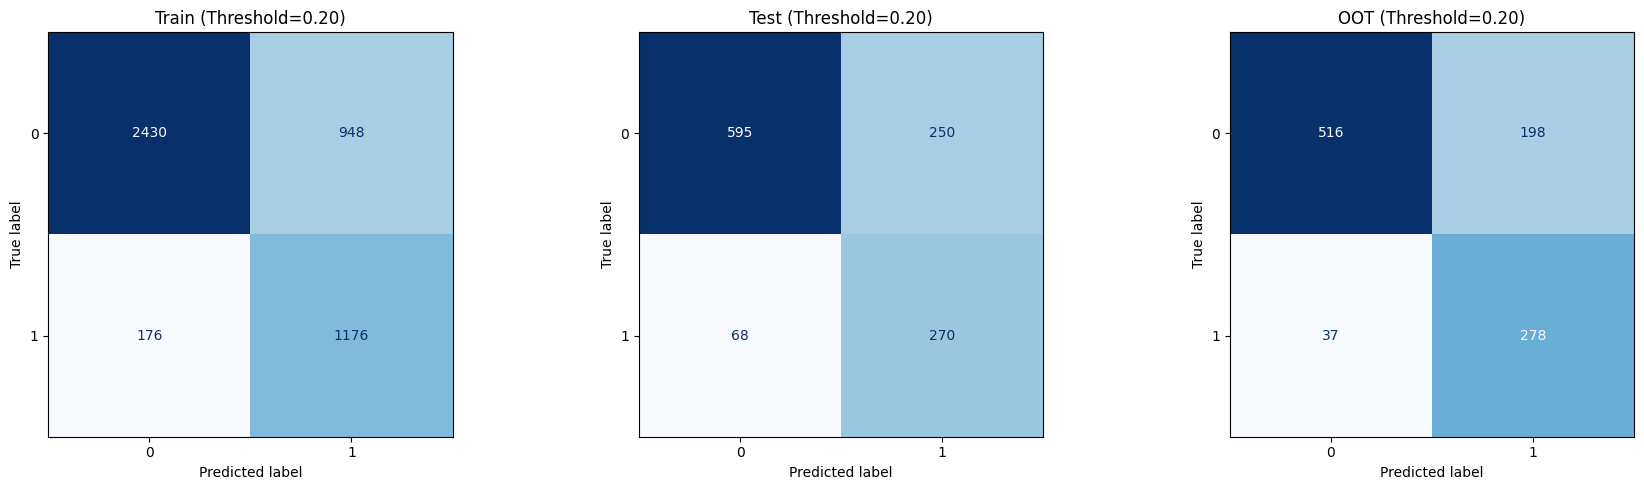

In [190]:
# Predictions
y_pred_train = (y_pred_proba_train > best_threshold).astype(int)
y_pred_test = (y_pred_proba_test > best_threshold).astype(int)
y_pred_oot = (y_pred_proba_oot > best_threshold).astype(int)

# Confusion matrices
cm_train = confusion_matrix(y_train_arr, y_pred_train)
cm_test = confusion_matrix(y_test_arr, y_pred_test)
cm_oot = confusion_matrix(y_oot_arr, y_pred_oot)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Train
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axs[0], cmap='Blues', colorbar=False)
axs[0].set_title(f"Train (Threshold={best_threshold:.2f})")
axs[0].grid(False)

# Test
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axs[1], cmap='Blues', colorbar=False)
axs[1].set_title(f"Test (Threshold={best_threshold:.2f})")
axs[1].grid(False)

# OOT
disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot)
disp_oot.plot(ax=axs[2], cmap='Blues', colorbar=False)
axs[2].set_title(f"OOT (Threshold={best_threshold:.2f})")
axs[2].grid(False)

plt.tight_layout()
plt.show()

In [191]:
print(f"Best Train F{beta}-Score: {max(f1_scores_train):.4f}")
print(f"Best Test F{beta}-Score: {max(f1_scores_test):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot):.4f}")

Best Train F1.5-Score: 0.7398
Best Test F1.5-Score: 0.6927
Best OOT F1.5-Score: 0.7728
